<a href="https://colab.research.google.com/github/linerocks/bertelsmann-2020/blob/master/notebook/LearningCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Observing Learning Curve Changes

[original source](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/learning_rate.ipynb)

A learning curve is a plot of model learning performance over experience or time.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.

Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model, as well as whether the training and validation datasets are suitably representative.

In [1]:
import os
import tensorflow.keras

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
#from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from keras.utils import plot_model

print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.4.0


In [2]:
!gsutil cp gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv .

Copying gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      


In [3]:
housing_df = pd.read_csv('housing_pre-proc.csv', error_bad_lines=False)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train.to_csv('./housing-train.csv', encoding='utf-8', index=False)
val.to_csv('./housing-val.csv', encoding='utf-8', index=False)
test.to_csv('./housing-test.csv', encoding='utf-8', index=False)

13076 train examples
3270 validation examples
4087 test examples


In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Next we initialize the training and validation datasets.
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

# Input Pipeline
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

# Next, we scale the numerical feature columns that we assigned to the variable "numeric cols".
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)
    
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

## Model 1 - hard cording the learning rate to .5

In [6]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
opt = keras.optimizers.Adam(learning_rate=.5)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
405/409 [============================>.] - ETA: 0s - loss: 24476531514.7852 - mse: 24476531514.7852WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

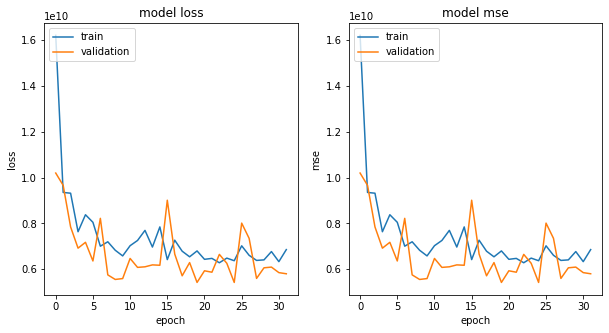

In [7]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left'); 
plot_curves(history, ['loss', 'mse'])

# Print .5

## Model 2 - hard cording the learning rate to .1

In [8]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
382/409 [===========================>..] - ETA: 0s - loss: 23644667606.4503 - mse: 23644667606.4503WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

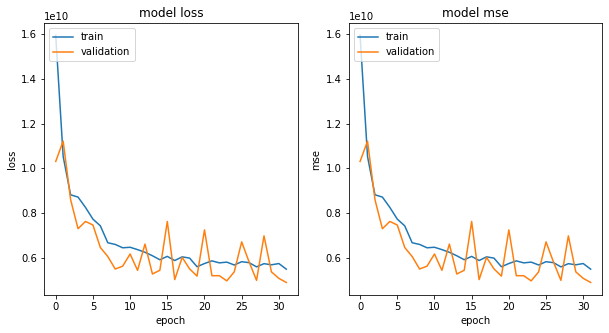

In [9]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  
plot_curves(history, ['loss', 'mse'])

# ME:  Add a print title:  .1

## Model 3 - hard cording the learning rate to .01

In [ ]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)  # Increase Epochs to 32

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
397/409 [============================>.] - ETA: 0s - loss: 36641408724.7960 - mse: 36641408724.7960WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

In [ ]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  
plot_curves(history, ['loss', 'mse'])

# Print .01 in title

## Model 4 - hard cording the learning rate to .001

In [ ]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)  # Increase Epochs to 32

In [ ]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  
        
plot_curves(history, ['loss', 'mse'])

# Print .001